<a href="https://colab.research.google.com/github/R-aryan/Image_Classification_VGG16/blob/master/Cat_vs_Dog_pytorch_tl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
train_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/train/'
train_dogs_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/train/Dogs/'
train_cats_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/train/Cats/'
val_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/val/'
val_dogs_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/val/Dogs/'
val_cats_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/val/Cats/'
test_data_dir= '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/test/'
test_data_files = os.listdir(test_data_dir)

In [0]:
# print("Printing train dir") # shows cats, dogs subfolders only
# !ls {train_dir} | head -n 5
# print("Printing train dog dir") # there is now dog images in dogs folder
# !ls {train_dogs_dir} | head -n 5
# print("Printing train cat dir") # there is now cat images in cats folder
# !ls {train_cats_dir} | head -n 5


In [18]:
pwd

'/content'

In [19]:
files = os.listdir(train_dir)
files

['Dogs', 'Cats']

In [20]:
files = os.listdir(train_dogs_dir)
len(files)

7996

In [21]:
files = os.listdir(train_cats_dir)
len(files)

12442

Now that data is in the right structure, it’s time to train our model. First is importing what I need for this notebook. But this is not the complete list of imports, we will import the rest as they are needed.

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
print(torch.__version__)
plt.ion()   # interactive mode


from PIL import Image

1.4.0


Let’s define training data augmentation and validation data transform.

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

As data augmentation I apply a little bit of rotation, random flips and resizing + crop. The scale of resizing is 0.96–1.0. I try to avoid giving scale less than 0.96 because you can still get the wanted variation in data and there is much less risk of cutting some important part of data off (e.g. head of the cat or dog, if we don’t have head part, it will be much harder for machine to learn how each class should look like). Also a moderate ratio change should be ok for our purpose (thinner or fatter, a cat is a cat right?). About Normalization, I used some hard coded value for mean and standard deviation. These values are known to work well and used frequently. Check this Facebook AI engineer’s recommendation for using those values and also official PyTorch example using the same value.

In [24]:
data_dir = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/'
CHECK_POINT_PATH = '/content/drive/My Drive/classification_Dataset/cat_VS_dogs/checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')


['Cats', 'Dogs']
Train image size: 20438
Validation image size: 98


Let’s take a look at what a mini batch (4 images) from training set look like using the next snippet of code.

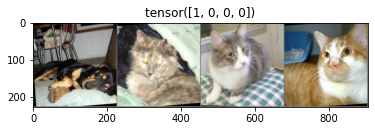

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
# Make a grid from batch
sample_train_images = torchvision.utils.make_grid(inputs)
imshow(sample_train_images, title=classes)

You will see randomly selected 4 images and title will say 0 for cat and 1 for dog. Next let’s define a function that trains our model and return some metric.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' % 
                          (epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc


The function first checks if saved checkpoint is passed. If yes, then it will load the saved parameter and start training from where it left off. If no, then it starts training the model it was passed (we will still use pretrained model from beginning). The function updates parameters only in train phase and prints out some metrics every epochs or whenever it has new best loss.
Now let’s define our model by downloading pretrained model. It takes some time to run next code if you never ran it before.

In [0]:
model_conv = torchvision.models.resnet50(pretrained=True)

resnet50 is a convolutional neural network architecture that is really powerful for solving computer vision problems. Less powerful but less resource consuming models you might be interested in using include resnet18 and resnet34. By giving pretrained=True as an argument you will download a model with the parameters trained with ImageNet data set. Since we need to change the model for our needs (binary class classification), we will change the last fully connected layer and define a loss function that’s useful for classification problem (cross entropy loss, which combines log softmax and negative log likelihood loss function). Optimzier is stochastic gradient descent optimizer and scheduler is exponential because it will reduce learning rate by the factor of 10 every 7 epochs (In reality I only trained 6 epochs).

In [0]:
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 2,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.019031929118292674, Val accuracy: 0.9897959183673468
Epoch 0/1
----------
[1, 199] loss: 0.214
[1, 399] loss: 0.213
[1, 599] loss: 0.203
[1, 799] loss: 0.191
[1, 999] loss: 0.188
[1, 1199] loss: 0.188
[1, 1399] loss: 0.195
[1, 1599] loss: 0.194
[1, 1799] loss: 0.191
[1, 1999] loss: 0.191
[1, 2199] loss: 0.193
[1, 2399] loss: 0.194
[1, 2599] loss: 0.191
[1, 2799] loss: 0.188
[1, 2999] loss: 0.189
[1, 3199] loss: 0.187
[1, 3399] loss: 0.186
[1, 3599] loss: 0.184
[1, 3799] loss: 0.186
[1, 3999] loss: 0.187
[1, 4199] loss: 0.184
[1, 4399] loss: 0.185
[1, 4599] loss: 0.186
[1, 4799] loss: 0.184
[1, 4999] loss: 0.183
train Loss: 0.1842 Acc: 0.9308
val Loss: 0.0173 Acc: 1.0000
New best model found!
New record loss: 0.017334300036333045, previous record loss: 0.019031929118292674

Epoch 1/1
----------
[2, 199] loss: 0.163
[2, 399] loss: 0.189
[2, 599] loss: 0.188
[2, 799] loss: 0.191
[2, 999] loss: 0.193
[2, 1199] loss: 0.196
[2, 1399] loss: 0.189
[2, 1599] loss: 

In [0]:
# for param in model_conv.parameters():
#     param.requires_grad = True
# model_conv = model_conv.to(device)
# # Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [0]:

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

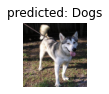

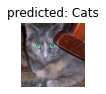

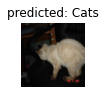

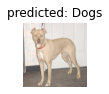

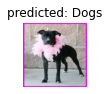

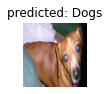

In [32]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:

for param in model_conv.parameters():
    param.requires_grad = True

model_conv = model_conv.to(device)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

In [34]:
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 2,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

checkpoint loaded
Val loss: 0.017334300036333045, Val accuracy: 0.9999999999999999
Epoch 0/1
----------
[1, 199] loss: 0.171
[1, 399] loss: 0.171
[1, 599] loss: 0.169
[1, 799] loss: 0.169
[1, 999] loss: 0.171
[1, 1199] loss: 0.169
[1, 1399] loss: 0.165
[1, 1599] loss: 0.165
[1, 1799] loss: 0.168
[1, 1999] loss: 0.167
[1, 2199] loss: 0.170
[1, 2399] loss: 0.170
[1, 2599] loss: 0.170
[1, 2799] loss: 0.172
[1, 2999] loss: 0.170
[1, 3199] loss: 0.172
[1, 3399] loss: 0.173
[1, 3599] loss: 0.173
[1, 3799] loss: 0.172
[1, 3999] loss: 0.173
[1, 4199] loss: 0.173
[1, 4399] loss: 0.174
[1, 4599] loss: 0.175
[1, 4799] loss: 0.175
[1, 4999] loss: 0.175
train Loss: 0.1742 Acc: 0.9332
val Loss: 0.0242 Acc: 0.9898

Epoch 1/1
----------
[2, 199] loss: 0.197
[2, 399] loss: 0.184
[2, 599] loss: 0.193
[2, 799] loss: 0.188
[2, 999] loss: 0.186
[2, 1199] loss: 0.189
[2, 1399] loss: 0.185
[2, 1599] loss: 0.187
[2, 1799] loss: 0.187
[2, 1999] loss: 0.187
[2, 2199] loss: 0.184
[2, 2399] loss: 0.185
[2, 2599] 

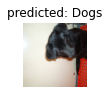

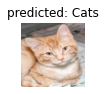

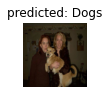

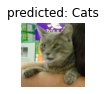

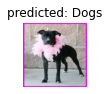

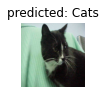

In [35]:

visualize_model(model_conv)

In [0]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

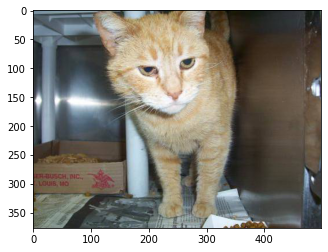

In [37]:
im = Image.open(f'{test_data_dir}/{test_data_files[0]}')
plt.imshow(im)

In [1]:

im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())
minibatch=minibatch.cuda()

NameError: ignored

In [49]:
model_conv.cuda()
model_conv(minibatch)


tensor([[ 3.9225, -4.7045]], device='cuda:0', grad_fn=<AddmmBackward>)

In [50]:

softMax = nn.Softmax(dim = 1)
preds = softMax(model_conv(minibatch))
preds

tensor([[9.9982e-01, 1.7918e-04]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [0]:

def predict_dog_prob_of_single_instance(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0,1].item()

In [0]:
def test_data_from_fname(fname):
    im = Image.open(f'{test_data_dir}/{fname}')
    return apply_test_transforms(im)

In [0]:

import re

def extract_file_id(fname):
    #print("Extracting id from " + fname)
    return int(re.search('\d+', fname).group())

extract_file_id("cat34432.jpg")

In [0]:

model_conv.eval()
id_to_dog_prob = {extract_file_id(fname): 
                  predict_dog_prob_of_single_instance(model_conv,
                                                      test_data_from_fname(fname))
                  for fname in test_data_files}

In [0]:

import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
ds.head()


In [0]:
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.head()